# Exploratory Data Analysis on the Bureau data

The goal in this step is to:
- Load the `bureau.csv` and `bureau_balance.csv`
- Explore the dataset (shape, missing %, key distributions)
- Aggregate the bureau information into SK_ID_CURR level (credit history with other lenders)
- Export the aggregated dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set PATH variables
RAW_DIR = Path("../data/raw")
CLEAN_DIR = Path("../data/clean")

bureau = pd.read_csv(RAW_DIR / "bureau.csv")
b_bal = pd.read_csv(RAW_DIR / "bureau_balance.csv")

print("bureau shape:", bureau.shape)
print("bureau_balance shape:", b_bal.shape)


bureau shape: (1716428, 17)
bureau_balance shape: (27299925, 3)


### 1. Check Missing Values

In [3]:
def missing_summary(df, top_n=20):
    mis = df.isnull().mean().sort_values(ascending=False)
    out = mis.to_frame("missing_frac").assign(missing_pct=lambda x: x["missing_frac"]*100)
    return out.head(top_n)

print("bureau missing:")
display(missing_summary(bureau))

print("bureau_balance missing:")
display(missing_summary(b_bal))


bureau missing:


,missing_frac,missing_pct
AMT_ANNUITY,0.714735,71.473490
AMT_CREDIT_MAX_OVERDUE,0.655133,65.513264
DAYS_ENDDATE_FACT,0.369170,36.916958
AMT_CREDIT_SUM_LIMIT,0.344774,34.477415
AMT_CREDIT_SUM_DEBT,0.150119,15.011932
DAYS_CREDIT_ENDDATE,0.061496,6.149573
AMT_CREDIT_SUM,0.000008,0.000757
CREDIT_ACTIVE,0.000000,0.000000
CREDIT_CURRENCY,0.000000,0.000000
DAYS_CREDIT,0.000000,0.000000


bureau_balance missing:


,missing_frac,missing_pct
SK_ID_BUREAU,0.0,0.0
MONTHS_BALANCE,0.0,0.0
STATUS,0.0,0.0


### 2. Check Bureau loan status timeline density

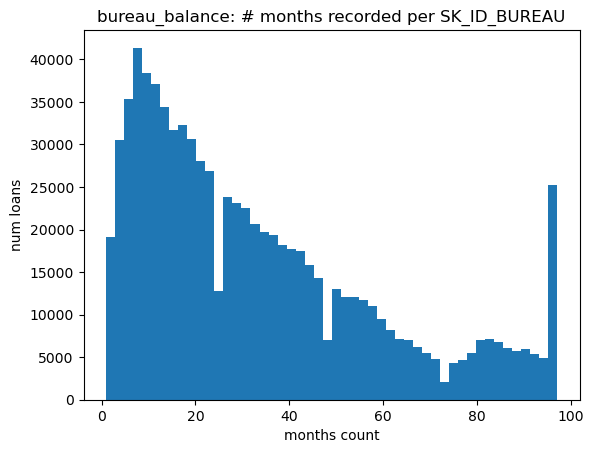

count    817395.000000
mean         33.398693
std          25.794666
min           1.000000
25%          13.000000
50%          26.000000
75%          48.000000
max          97.000000
dtype: float64


In [4]:
records_per_loan = b_bal.groupby("SK_ID_BUREAU").size()
plt.hist(records_per_loan, bins=50)
plt.title("bureau_balance: # months recorded per SK_ID_BUREAU")
plt.xlabel("months count")
plt.ylabel("num loans")
plt.show()

print(records_per_loan.describe())


### 3. Compare Active vs Closed loans and DAYS_CREDIT

CREDIT_ACTIVE
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: count, dtype: int64


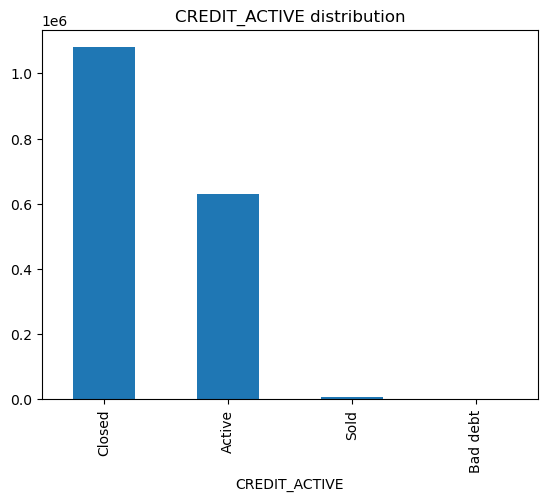

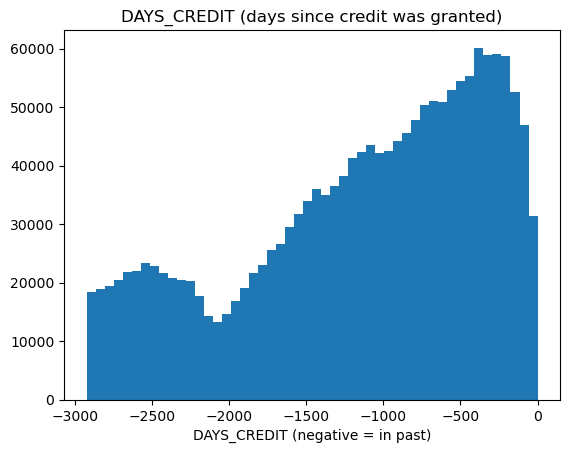

In [5]:
if "CREDIT_ACTIVE" in bureau.columns:
    active_counts = bureau["CREDIT_ACTIVE"].value_counts(dropna=False)
    print(active_counts)
    active_counts.plot(kind="bar")
    plt.title("CREDIT_ACTIVE distribution")
    plt.show()

if "DAYS_CREDIT" in bureau.columns:
    plt.hist(bureau["DAYS_CREDIT"], bins=50)
    plt.title("DAYS_CREDIT (days since credit was granted)")
    plt.xlabel("DAYS_CREDIT (negative = in past)")
    plt.show()


### 4. Debt / limits distributions

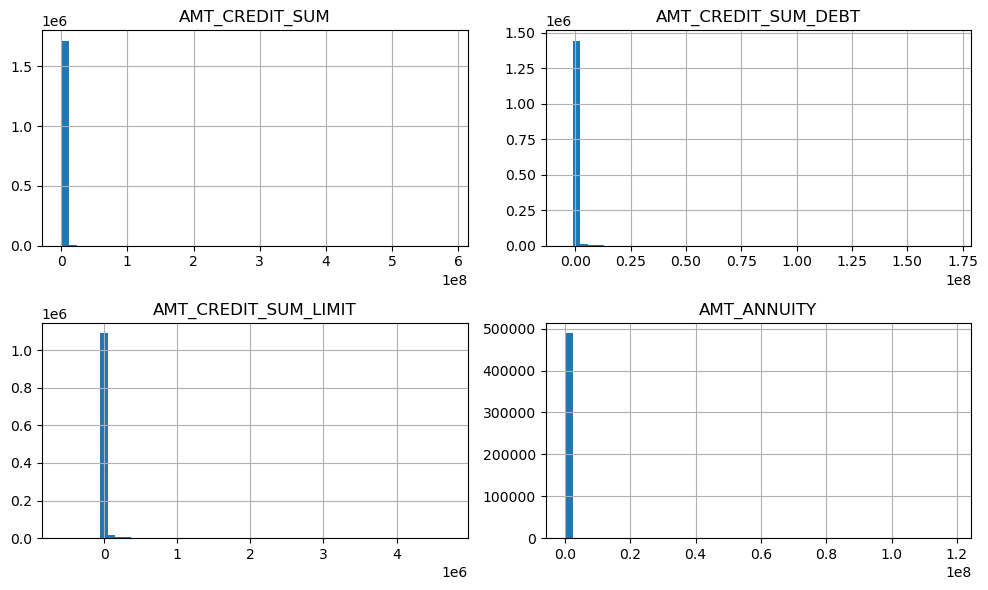

In [6]:
credit_cols = [
    "AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT",
    "AMT_CREDIT_SUM_LIMIT",
    "AMT_ANNUITY"
]
bureau[credit_cols].hist(bins=50, layout=(2,2), figsize=(10,6))
plt.tight_layout()
plt.show()


### 5. Summarize the bureau_balance per SK_ID_BUREAU
- NUM_MONTHS: count of rows
- BAD_MONTH_RATE: share of 'bad' status months


In [7]:
def summarize_bureau_balance(df_bb: pd.DataFrame) -> pd.DataFrame:
    good_statuses = {"C","X","0"}
    bb = df_bb.copy()
    bb["BAD_STATUS_MONTH"] = ~bb["STATUS"].isin(good_statuses)
    agg_bb = (
        bb.groupby("SK_ID_BUREAU")
        .agg(
            NUM_MONTHS=("MONTHS_BALANCE","count"),
            NUM_BAD_MONTHS=("BAD_STATUS_MONTH","sum")
        )
        .assign(BAD_MONTH_RATE=lambda x: x["NUM_BAD_MONTHS"] / x["NUM_MONTHS"])
        .reset_index()
    )
    return agg_bb

bb_summary = summarize_bureau_balance(b_bal)
bureau_enriched = bureau.merge(bb_summary, on="SK_ID_BUREAU", how="left")

print("bureau_enriched shape:", bureau_enriched.shape)
bureau_enriched.head()


bureau_enriched shape: (1716428, 20)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,NUM_MONTHS,NUM_BAD_MONTHS,BAD_MONTH_RATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN


### Feature Engineering: aggregate to SK_ID_CURR

For each SK_ID_CURR:
- BUREAU_LOAN_COUNT
- BUREAU_ACTIVE_LOAN_COUNT / BUREAU_CLOSED_LOAN_COUNT
- TOTAL_CREDIT_SUM stats
- DEBT_TO_CREDIT_SUM mean, etc.
- BAD_MONTH_RATE stats


In [8]:
def make_bureau_agg(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["IS_ACTIVE"] = (d["CREDIT_ACTIVE"]=="Active").astype(int)
    d["IS_CLOSED"] = (d["CREDIT_ACTIVE"]=="Closed").astype(int)

    d["DEBT_TO_CREDIT_SUM"] = d["AMT_CREDIT_SUM_DEBT"] / d["AMT_CREDIT_SUM"]
    d["LIMIT_TO_SUM"] = d["AMT_CREDIT_SUM_LIMIT"] / d["AMT_CREDIT_SUM"]

    aggs = {
        "SK_ID_BUREAU": "count",
        "IS_ACTIVE": "sum",
        "IS_CLOSED": "sum",
        "AMT_CREDIT_SUM": ["sum","mean","max"],
        "AMT_CREDIT_SUM_DEBT": ["sum","mean","max"],
        "DEBT_TO_CREDIT_SUM": "mean",
        "LIMIT_TO_SUM": "mean",
        "DAYS_CREDIT": ["min","max","mean"],
        "DAYS_CREDIT_ENDDATE": ["min","mean"],
        "DAYS_ENDDATE_FACT": ["min","mean"],
        "BAD_MONTH_RATE": ["max","mean"],
        "NUM_MONTHS": "mean"
    }

    agg_df = d.groupby("SK_ID_CURR").agg(aggs)
    agg_df.columns = [
        "_".join([c for c in col if c]) for col in agg_df.columns.to_flat_index()
    ]
    agg_df = agg_df.rename(columns={
        "SK_ID_BUREAU_count":"BUREAU_LOAN_COUNT",
        "IS_ACTIVE_sum":"BUREAU_ACTIVE_LOAN_COUNT",
        "IS_CLOSED_sum":"BUREAU_CLOSED_LOAN_COUNT",
        "BAD_MONTH_RATE_max":"BUREAU_MAX_BAD_MONTH_RATE",
        "BAD_MONTH_RATE_mean":"BUREAU_MEAN_BAD_MONTH_RATE",
        "NUM_MONTHS_mean":"BUREAU_AVG_NUM_MONTHS_REPORTED"
    })
    return agg_df.reset_index()

bureau_agg = make_bureau_agg(bureau_enriched)
print("bureau_agg shape:", bureau_agg.shape)
bureau_agg.head()


bureau_agg shape: (305811, 22)


,SK_ID_CURR,BUREAU_LOAN_COUNT,BUREAU_ACTIVE_LOAN_COUNT,BUREAU_CLOSED_LOAN_COUNT,AMT_CREDIT_SUM_sum,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_DEBT_sum,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_max,...,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_mean,DAYS_ENDDATE_FACT_min,DAYS_ENDDATE_FACT_mean,BUREAU_MAX_BAD_MONTH_RATE,BUREAU_MEAN_BAD_MONTH_RATE,BUREAU_AVG_NUM_MONTHS_REPORTED
0,100001,7,3,4,1453365.000,207623.571429,378000.0,596686.5,85240.928571,373239.0,...,-1572,-49,-735.000000,-1329.0,82.428571,-1328.0,-825.500000,0.052632,0.007519,24.571429
1,100002,8,2,6,865055.565,108131.945625,450000.0,245781.0,49156.200000,245781.0,...,-1437,-103,-874.000000,-1072.0,-349.000000,-1185.0,-697.500000,0.500000,0.255682,13.750000
2,100003,4,1,3,1017400.500,254350.125000,810000.0,0.0,0.000000,0.0,...,-2586,-606,-1400.750000,-2434.0,-544.500000,-2131.0,-1097.333333,NaN,NaN,NaN
3,100004,2,0,2,189037.800,94518.900000,94537.8,0.0,0.000000,0.0,...,-1326,-408,-867.000000,-595.0,-488.500000,-683.0,-532.500000,NaN,NaN,NaN
4,100005,3,2,1,657126.000,219042.000000,568800.0,568408.5,189469.500000,543087.0,...,-373,-62,-190.666667,-128.0,439.333333,-123.0,-123.000000,0.000000,0.000000,7.000000


### Save bureau_agg

In [9]:
bureau_agg_path = CLEAN_DIR / "bureau_agg.csv"
bureau_agg.to_csv(bureau_agg_path, index=False)
print(f"Saved {bureau_agg_path}")


Saved ../data/clean/bureau_agg.csv
